In [1]:
# Write a more robust, fixed script with:
# - Multi-host fallback (archives.nseindia.com and nsearchives.nseindia.com)
# - Cookie prefetch to avoid 403
# - Longer backoff window + clearer logging
# - Optional local file fallback
# - Safer forward/discount inference with fallbacks
# Save as /mnt/data/nifty_bl_range_eod_nse_fixed.py

"""
NIFTY Range/Breakout via Breeden–Litzenberger (EOD, free NSE data) — FIXED
---------------------------------------------------------------------------
Improvements vs previous version:
- Tries BOTH hosts: archives.nseindia.com AND nsearchives.nseindia.com
- Prefetches cookies from https://www.nseindia.com to avoid 403 blocks
- Backoff window configurable (default 14 days) and verbose URL/status logging
- Optional --local-zip to use a bhavcopy ZIP you already downloaded
- Safer forward/discount inference with fallbacks if regression misbehaves
- Better messages when chain is too small

Usage examples:
    python nifty_bl_range_eod_nse_fixed.py --date 2025-08-20
    python nifty_bl_range_eod_nse_fixed.py --date 2025-08-20 --k 1.2
    python nifty_bl_range_eod_nse_fixed.py --date 2025-08-20 --max-back 21
    python nifty_bl_range_eod_nse_fixed.py --date 2025-08-20 --local-zip C:\path\to\fo20AUG2025bhav.csv.zip

Outputs:
- Plots & CSV saved in out_nifty_bl/
- Final prediction printed to stdout
"""

import io
import os
import math
import zipfile
import argparse
import datetime as dt
from typing import Tuple, Dict, Optional

import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# -----------------------------
# Black–Scholes helper functions
# -----------------------------

def _norm_cdf(x: float) -> float:
    return 0.5 * (1.0 + math.erf(x / math.sqrt(2.0)))

def _bs_call_from_forward(F0: float, K: float, T: float, sigma: float, D: float) -> float:
    if sigma <= 1e-8 or T <= 0:
        return max(D * (F0 - K), 0.0)
    vol_sqrt_t = sigma * math.sqrt(T)
    d1 = (math.log(F0 / K) / vol_sqrt_t) + 0.5 * vol_sqrt_t
    d2 = d1 - vol_sqrt_t
    return D * (F0 * _norm_cdf(d1) - K * _norm_cdf(d2))

def implied_vol_from_call(F0: float, K: float, T: float, D: float, C_obs: float,
                          tol: float = 1e-6, max_iter: int = 100) -> float:
    lo, hi = 1e-6, 5.0
    for _ in range(max_iter):
        mid = 0.5 * (lo + hi)
        C_mid = _bs_call_from_forward(F0, K, T, mid, D)
        if abs(C_mid - C_obs) < tol:
            return mid
        if C_mid > C_obs:
            hi = mid
        else:
            lo = mid
    return 0.5 * (lo + hi)

# -------------------------------------------
# NSE EOD derivatives (bhavcopy) fetcher
# -------------------------------------------

HOSTS = [
    "https://archives.nseindia.com",
    "https://nsearchives.nseindia.com",
]

def _month_abbr_upper(d: dt.date) -> str:
    return d.strftime("%b").upper()

def _ddmmmyyyy_upper(d: dt.date) -> str:
    return d.strftime("%d%b%Y").upper()

def nse_bhavcopy_urls_for_date(d: dt.date):
    y = d.strftime("%Y")
    m_abbr = _month_abbr_upper(d)
    ddmmmyyyy = _ddmmmyyyy_upper(d)
    path = f"/content/historical/DERIVATIVES/{y}/{m_abbr}/fo{ddmmmyyyy}bhav.csv.zip"
    return [host + path for host in HOSTS]

def fetch_bhavcopy(date: dt.date, max_back: int = 14, local_zip: Optional[str] = None) -> Tuple[pd.DataFrame, dt.date, str]:
    """
    Try the given date; if 404/connection error, step back one day up to max_back.
    Returns (bhav_df, actual_date_used, source_url_or_path)
    """
    if local_zip:
        if not os.path.exists(local_zip):
            raise FileNotFoundError(f"--local-zip not found: {local_zip}")
        with zipfile.ZipFile(local_zip, 'r') as zf:
            csv_name = [n for n in zf.namelist() if n.lower().endswith(".csv")][0]
            with zf.open(csv_name) as f:
                df = pd.read_csv(f)
        return df, date, local_zip

    headers = {
        "User-Agent": "Mozilla/5.0",
        "Accept": "text/html,application/xhtml+xml,application/xml;q=0.9,*/*;q=0.8",
        "Referer": "https://www.nseindia.com/",
        "Connection": "keep-alive",
        "Accept-Encoding": "gzip, deflate, br",
    }
    session = requests.Session()

    # Prefetch cookie from main site to avoid 403
    try:
        session.get("https://www.nseindia.com/", headers=headers, timeout=15)
    except Exception:
        pass

    for i in range(max_back + 1):
        d_try = date - dt.timedelta(days=i)
        urls = nse_bhavcopy_urls_for_date(d_try)
        for url in urls:
            try:
                print(f"  Trying: {url}")
                resp = session.get(url, headers=headers, timeout=30)
                if resp.status_code == 200 and resp.content:
                    # Ensure it's a zip
                    try:
                        zf = zipfile.ZipFile(io.BytesIO(resp.content))
                        csv_name = [n for n in zf.namelist() if n.lower().endswith(".csv")][0]
                        with zf.open(csv_name) as f:
                            df = pd.read_csv(f)
                        return df, d_try, url
                    except zipfile.BadZipFile:
                        print("    Received 200 but content is not a ZIP (likely blocked).")
                else:
                    print(f"    Status: {resp.status_code}")
            except requests.RequestException as e:
                print(f"    Request failed: {e}")
    raise RuntimeError("Could not download bhavcopy within the backoff window. "
                       "Try another date, increase --max-back, or use --local-zip.")

# --------------------------------------------------------
# Chain builder (NIFTY OPTIDX, nearest expiry > trade date)
# --------------------------------------------------------

def build_nifty_chain(df: pd.DataFrame, trade_date: dt.date, symbol: str = "NIFTY") -> Tuple[pd.DataFrame, Dict[str, float]]:
    # Normalize columns
    df2 = df.copy()
    df2.columns = [c.upper() for c in df2.columns]
    needed = ["INSTRUMENT", "SYMBOL", "EXPIRY_DT", "STRIKE_PR", "OPTION_TYP"]
    for col in needed:
        if col not in df2.columns:
            raise ValueError(f"Bhavcopy missing column: {col}")

    price_col = "SETTLE_PR" if "SETTLE_PR" in df2.columns else ("CLOSE" if "CLOSE" in df2.columns else None)
    if price_col is None:
        raise ValueError("Bhavcopy missing both SETTLE_PR and CLOSE columns for prices.")

    d = df2[(df2["INSTRUMENT"] == "OPTIDX") & (df2["SYMBOL"] == symbol)]
    if d.empty:
        raise ValueError(f"No {symbol} OPTIDX rows in this bhavcopy.")

    d["EXPIRY_DT"] = pd.to_datetime(d["EXPIRY_DT"], dayfirst=True, errors="coerce").dt.date
    expiries = sorted([e for e in d["EXPIRY_DT"].dropna().unique().tolist() if e > trade_date])
    if not expiries:
        # If no later expiry (e.g., using last trading day), allow same-day expiry as fallback
        expiries = sorted([e for e in d["EXPIRY_DT"].dropna().unique().tolist() if e >= trade_date])
        if not expiries:
            raise ValueError("No expiry found at/after trade date in this file.")
    expiry_chosen = expiries[0]

    de = d[d["EXPIRY_DT"] == expiry_chosen].copy()
    de["STRIKE_PR"] = pd.to_numeric(de["STRIKE_PR"], errors="coerce")
    de[price_col] = pd.to_numeric(de[price_col], errors="coerce")
    de = de.dropna(subset=["STRIKE_PR", price_col, "OPTION_TYP"])

    calls = de[de["OPTION_TYP"] == "CE"][["STRIKE_PR", price_col]].rename(columns={"STRIKE_PR": "strike", price_col: "call_price"})
    puts  = de[de["OPTION_TYP"] == "PE"][["STRIKE_PR", price_col]].rename(columns={"STRIKE_PR": "strike", price_col: "put_price"})
    chain = pd.merge(calls, puts, on="strike", how="inner")

    chain = chain[(chain["call_price"] > 0) & (chain["put_price"] > 0)]
    chain = chain.drop_duplicates(subset=["strike"]).sort_values("strike").reset_index(drop=True)

    if len(chain) < 6:
        raise ValueError(f"Chain too small after cleaning ({len(chain)} rows). Try another date.")

    T = (expiry_chosen - trade_date).days / 365.0
    if T <= 0:
        # Same-day expiry: treat a tiny positive T (approx 1/365)
        T = 1.0 / 365.0

    meta = {"T": T, "trade_date": trade_date.isoformat(), "expiry": expiry_chosen.isoformat(), "price_col": price_col}
    return chain, meta

# --------------------------------------------------------
# Forward/discount, IVs, smile fit, BL CDF
# --------------------------------------------------------

def infer_forward_and_discount(df: pd.DataFrame, T: float) -> Tuple[float, float]:
    """
    Primary: linear regression on parity  (C-P) = D*(F0 - K).
    Fallbacks if D is non-sensical.
    """
    y = df["call_price"].values - df["put_price"].values
    X = df["strike"].values
    A = np.vstack([np.ones_like(X), X]).T
    a, b = np.linalg.lstsq(A, y, rcond=None)[0]
    D = -b
    if D <= 0 or D > 2:
        # Fallback 1: assume a reasonable discount from a guess rate (7%)
        D = math.exp(-0.07 * max(T, 1e-6))
        # Solve F0 minimizing squared error -> closed form mean
        F0 = np.mean(X + y / D)
        return float(F0), float(D)
    F0 = a / D
    return float(F0), float(D)

def prices_to_ivs(df: pd.DataFrame, F0: float, D: float, T: float) -> pd.Series:
    ivs = []
    for K, C in zip(df["strike"].values, df["call_price"].values):
        try:
            iv = implied_vol_from_call(F0, K, T, D, C)
        except Exception:
            iv = np.nan
        ivs.append(iv)
    s = pd.Series(ivs, index=df.index, name="iv").astype(float)
    return s.dropna()

def fit_iv_quadratic(df: pd.DataFrame, F0: float) -> Tuple[np.ndarray, np.ndarray]:
    m = np.log(df["strike"].values / F0)
    y = df["iv"].values
    if len(y) < 5:
        raise ValueError("Too few IV points to fit smile.")
    coeffs = np.polyfit(m, y, deg=2)
    return coeffs, m

def iv_from_poly(coeffs: np.ndarray, K: float, F0: float) -> float:
    m = math.log(K / F0)
    return max(1e-4, float(np.polyval(coeffs, m)))

def build_call_curve(coeffs: np.ndarray, F0: float, D: float, T: float, K_min: float, K_max: float, n: int = 1201) -> Tuple[np.ndarray, np.ndarray]:
    K_grid = np.linspace(K_min, K_max, n)
    C_grid = np.array([_bs_call_from_forward(F0, K, T, iv_from_poly(coeffs, K, F0), D) for K in K_grid])
    return K_grid, C_grid

def cdf_from_call_curve(K_grid: np.ndarray, C_grid: np.ndarray, D: float) -> np.ndarray:
    dK = K_grid[1] - K_grid[0]
    dC_dK = np.gradient(C_grid, dK)
    F = 1.0 + (1.0 / D) * dC_dK
    F = np.clip(F, 0.0, 1.0)
    F_monotone = np.maximum.accumulate(F)
    if F_monotone[-1] > 0:
        F_monotone = F_monotone / F_monotone[-1]
    return F_monotone

def choose_band_bounds(F0: float, D: float, coeffs: np.ndarray, T: float, k: float = 1.0) -> Tuple[float, float, float]:
    sigma_atm = float(np.polyval(coeffs, 0.0))
    b = k * sigma_atm * math.sqrt(T)
    S0_est = F0 * D
    L = S0_est * (1.0 - b)
    U = S0_est * (1.0 + b)
    return S0_est, L, U

def band_breakout_probabilities(K_grid: np.ndarray, F_cdf: np.ndarray, L: float, U: float):
    F_L = float(np.interp(L, K_grid, F_cdf))
    F_U = float(np.interp(U, K_grid, F_cdf))
    p_range = max(0.0, F_U - F_L)
    p_down = max(0.0, F_L)
    p_up = max(0.0, 1.0 - F_U)
    s = p_range + p_down + p_up
    if s > 0:
        p_range, p_down, p_up = p_range/s, p_down/s, p_up/s
    return {"p_range": p_range, "p_down": p_down, "p_up": p_up}

def final_prediction(p, thresh_range: float = 0.55) -> str:
    if p["p_range"] >= thresh_range:
        return f"Predict: RANGE (≥ band), confidence ~{p['p_range']:.1%}"
    if p["p_up"] >= p["p_down"]:
        return f"Predict: UPSIDE BREAKOUT (> U), prob ~{p['p_up']:.1%}"
    else:
        return f"Predict: DOWNSIDE BREAKOUT (< L), prob ~{p['p_down']:.1%}"

# --------------------
# Main
# --------------------

def main():
    parser = argparse.ArgumentParser(description="NIFTY Range/Breakout via BL using free NSE EOD data (fixed)")
    parser.add_argument("--date", required=True, help="Trade date (YYYY-MM-DD) to fetch bhavcopy for (will backtrack if holiday)")
    parser.add_argument("--symbol", default="NIFTY", help="Symbol for OPTIDX (default: NIFTY)")
    parser.add_argument("--k", type=float, default=1.0, help="Band width multiplier (×ATM implied move)")
    parser.add_argument("--max-back", type=int, default=14, help="How many days to step back if file not found (default 14)")
    parser.add_argument("--local-zip", type=str, default=None, help="Path to local bhavcopy ZIP (skips download)")
    args = parser.parse_args()

    trade_date = dt.datetime.strptime(args.date, "%Y-%m-%d").date()

    print(f"Fetching NSE bhavcopy around {trade_date} ...")
    df_raw, used_date, src = fetch_bhavcopy(trade_date, max_back=args.max_back, local_zip=args.local_zip)
    if used_date != trade_date:
        print(f"  Using previous business day {used_date} (requested date had no file).")
    print(f"  Source: {src}")

    print("Building option chain ...")
    chain, meta = build_nifty_chain(df_raw, used_date, symbol=args.symbol)
    T = meta["T"]

    # Determine a central region around ATM to avoid extreme staleness
    F0_tmp, D_tmp = infer_forward_and_discount(chain, T)
    S0_tmp = F0_tmp * D_tmp
    mask_central = (chain["strike"] >= 0.85 * S0_tmp) & (chain["strike"] <= 1.15 * S0_tmp)
    chain_central = chain[mask_central].copy()
    if len(chain_central) < 8:
        chain_central = chain.copy()

    print("Inferring forward/discount (put–call parity) ...")
    F0, D = infer_forward_and_discount(chain_central, T)
    if not (0 < D < 2):
        raise ValueError(f"Bad discount factor inferred: {D}")

    print("Converting prices to IVs and fitting smile ...")
    chain_central["iv"] = prices_to_ivs(chain_central, F0, D, T)
    chain_central = chain_central.dropna(subset=["iv"])
    if len(chain_central) < 6:
        raise ValueError("Too few valid IVs after inversion. Try another date.")
    coeffs, _ = fit_iv_quadratic(chain_central, F0)

    print("Building smooth call curve and BL CDF ...")
    K_min, K_max = chain_central["strike"].min(), chain_central["strike"].max()
    K_grid, C_grid = build_call_curve(coeffs, F0, D, T, K_min, K_max, n=1201)
    F_cdf = cdf_from_call_curve(K_grid, C_grid, D)

    print("Computing band probabilities and final prediction ...")
    S0_est, L, U = choose_band_bounds(F0, D, coeffs, T, k=args.k)
    probs = band_breakout_probabilities(K_grid, F_cdf, L, U)
    pred = final_prediction(probs, thresh_range=0.55)

    # --- Report ---
    print("\n=== Data snapshot ===")
    print(f"Trade date used   : {used_date}")
    print(f"Expiry chosen     : {meta['expiry']}")
    print(f"Rows in chain     : {len(chain)} (central fit on {len(chain_central)})")

    print("\n=== Inferred market inputs ===")
    print(f"Discount factor D : {D:.6f}  (implied r ≈ {-(math.log(D)/T):.4%} annualized)")
    print(f"Forward F0        : {F0:.2f}")
    print(f"Spot estimate S0  : {S0_est:.2f}")

    sigma_atm = float(np.polyval(coeffs, 0.0))
    print(f"ATM implied vol   : {sigma_atm:.2%} for T = {T:.5f} years")

    print("\n=== Band (k × ATM move; k={}) ===".format(args.k))
    print(f"L ≈ {L:.2f}   U ≈ {U:.2f}")

    print("\n=== Probabilities (risk-neutral) ===")
    print(f"P_range  (L ≤ S_T ≤ U): {probs['p_range']:.2%}")
    print(f"P_up     (S_T > U)    : {probs['p_up']:.2%}")
    print(f"P_down   (S_T < L)    : {probs['p_down']:.2%}")

    print("\n=== Final model output ===")
    print(pred)

    # --- Visualizations ---
    os.makedirs("out_nifty_bl", exist_ok=True)

    # 1) Smile (raw IVs vs fitted IVs)
    plt.figure()
    m_vals = np.log(chain_central["strike"].values / F0)
    plt.scatter(m_vals, chain_central["iv"].values, label="Raw IVs")
    m_dense = np.linspace(m_vals.min(), m_vals.max(), 300)
    iv_fit = np.polyval(coeffs, m_dense)
    plt.plot(m_dense, iv_fit, label="Fitted IV (quadratic)")
    plt.xlabel("log-moneyness m = ln(K/F0)")
    plt.ylabel("Implied Volatility")
    plt.legend()
    plt.title(f"{args.symbol} Implied Vol Smile (raw vs fitted) — {used_date} → {meta['expiry']}")
    plt.tight_layout()
    smile_path = os.path.join("out_nifty_bl", f"{args.symbol}_smile_{used_date}_{meta['expiry']}.png")
    plt.savefig(smile_path, dpi=160)
    plt.show()

    # 2) CDF with band
    plt.figure()
    plt.plot(K_grid, F_cdf, label="Risk-neutral CDF via BL")
    plt.axvline(L, linestyle="--", label="L (band lower)")
    plt.axvline(U, linestyle="--", label="U (band upper)")
    plt.xlabel("Terminal Price S_T (≈ strike K)")
    plt.ylabel("CDF  F_Q(S_T ≤ K)")
    plt.legend()
    plt.title(f"{args.symbol} Risk-neutral CDF and Range Band — {used_date} → {meta['expiry']}")
    plt.tight_layout()
    cdf_path = os.path.join("out_nifty_bl", f"{args.symbol}_cdf_{used_date}_{meta['expiry']}.png")
    plt.savefig(cdf_path, dpi=160)
    plt.show()

    # 3) Save smooth curve & CDF
    out = pd.DataFrame({"K": K_grid, "C_smooth": C_grid, "F_cdf": F_cdf})
    csv_path = os.path.join("out_nifty_bl", f"{args.symbol}_call_curve_and_cdf_{used_date}_{meta['expiry']}.csv")
    out.to_csv(csv_path, index=False)

    print("\nSaved:")
    print(" ", smile_path)
    print(" ", cdf_path)
    print(" ", csv_path)

if __name__ == "__main__":
    main()


usage: ipykernel_launcher.py [-h] --date DATE [--symbol SYMBOL] [--k K]
                             [--max-back MAX_BACK] [--local-zip LOCAL_ZIP]
ipykernel_launcher.py: error: the following arguments are required: --date


SystemExit: 2

c:\Users\adavy\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\interactiveshell.py:3585: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [3]:
# Step 1: setup
import io, zipfile, gzip, requests, pandas as pd, datetime as dt
from pathlib import Path

DATE   = "2025-08-29"   # <- use the date that worked in your probe
SYMBOL = "NIFTY"        # OPTIDX symbol
SAVE_DIR = Path("data_nse_udiff"); SAVE_DIR.mkdir(exist_ok=True)

def fetch_udiff_fo(date_str: str):
    """Download FO BhavCopy (UDiFF) as CSV DataFrame (tries .zip then .gz)."""
    d = dt.datetime.strptime(date_str, "%Y-%m-%d").date()
    ymd = d.strftime("%Y%m%d")
    base = f"https://archives.nseindia.com/content/fo/BhavCopy_NSE_FO_0_0_0_{ymd}_F_0000.csv"
    urls = [base + ".zip", base + ".gz"]

    headers = {
        "User-Agent": "Mozilla/5.0",
        "Accept": "text/html,application/xhtml+xml,application/xml;q=0.9,*/*;q=0.8",
        "Referer": "https://www.nseindia.com/",
        "Connection": "keep-alive",
        "Accept-Encoding": "gzip, deflate, br",
    }
    s = requests.Session()
    # cookie prefetch helps avoid some blocks
    try: s.get("https://www.nseindia.com/", headers=headers, timeout=15)
    except: pass

    last_err = None
    for url in urls:
        r = s.get(url, headers=headers, timeout=30)
        if r.status_code == 200 and r.content:
            raw = io.BytesIO(r.content)
            try:
                if url.endswith(".zip"):
                    zf = zipfile.ZipFile(raw)
                    name = [n for n in zf.namelist() if n.lower().endswith(".csv")][0]
                    with zf.open(name) as f:
                        return pd.read_csv(f), url
                else:
                    with gzip.GzipFile(fileobj=raw) as gz:
                        return pd.read_csv(gz), url
            except Exception as e:
                last_err = f"parse error: {e}"
        else:
            last_err = f"http {r.status_code}"
    raise RuntimeError(f"UDiFF fetch failed for {date_str}: {last_err}")


In [5]:
raw_df, src_url = fetch_udiff_fo(DATE)
raw_path = SAVE_DIR / f"fo_{DATE.replace('-','')}.csv"
raw_df.to_csv(raw_path, index=False)

print("Saved RAW:", raw_path)
print("Source   :", src_url)
print("Rows     :", len(raw_df))
print("Columns  :", list(raw_df.columns)[:20], "...")
raw_df.head(3)

Saved RAW: data_nse_udiff\fo_20250829.csv
Source   : https://archives.nseindia.com/content/fo/BhavCopy_NSE_FO_0_0_0_20250829_F_0000.csv.zip
Rows     : 29199
Columns  : ['TradDt', 'BizDt', 'Sgmt', 'Src', 'FinInstrmTp', 'FinInstrmId', 'ISIN', 'TckrSymb', 'SctySrs', 'XpryDt', 'FininstrmActlXpryDt', 'StrkPric', 'OptnTp', 'FinInstrmNm', 'OpnPric', 'HghPric', 'LwPric', 'ClsPric', 'LastPric', 'PrvsClsgPric'] ...


,TradDt,BizDt,Sgmt,Src,FinInstrmTp,FinInstrmId,ISIN,TckrSymb,SctySrs,XpryDt,...,TtlTradgVol,TtlTrfVal,TtlNbOfTxsExctd,SsnId,NewBrdLotQty,Rmks,Rsvd1,Rsvd2,Rsvd3,Rsvd4
0,2025-08-29,2025-08-29,FO,NSE,STO,54736,NaN,ABCAPITAL,NaN,2025-11-25,...,0,0.0,0,F1,3100,NaN,NaN,NaN,NaN,NaN
1,2025-08-29,2025-08-29,FO,NSE,STO,61407,NaN,ABCAPITAL,NaN,2025-09-30,...,0,0.0,0,F1,3100,NaN,NaN,NaN,NaN,NaN
2,2025-08-29,2025-08-29,FO,NSE,STO,61385,NaN,ABCAPITAL,NaN,2025-09-30,...,0,0.0,0,F1,3100,NaN,NaN,NaN,NaN,NaN


In [8]:
import pandas as pd
import numpy as np
import datetime as dt
from pathlib import Path

def build_min_chain_udiff_basic(
    df: pd.DataFrame,
    trade_date: str,
    symbol: str | None = "NIFTY",
    prefer_symbols=("NIFTY","BANKNIFTY","FINNIFTY","MIDCPNIFTY","NIFTYIT"),
):
    """
    Minimal CE/PE chain builder for UDiFF FO files.
    Returns (chain_df, meta) where chain_df has only [strike, call_price, put_price].
    - If `symbol` is None or not present, picks the best available (prefers prefer_symbols).
    - Uses settlement price if present, else close, else last.
    """

    d = df.copy()
    d.columns = [c.upper() for c in d.columns]  # normalize header

    # Map core columns (handle multiple possible names)
    def pick(*names):
        for n in names:
            if n in d.columns:
                return n
        return None

    col_ticker = pick("TCKRSYMB","SYMBOL","SYMB","TCKRSYMBOL")
    col_opttyp = pick("OPTNTP","OPTION_TYP","OPTIONTYPE","OPT_TYPE")
    col_expiry = pick("XPRYDT","EXPIRY_DT","EXPIRY","EXPDATE")
    col_strike = pick("STRKPRIC","STRIKE_PR","STRIKE","STRIKEPRICE")
    col_price  = pick("STTLMPRIC","CLSPRIC","CLOSE","LASTPRIC","SETTLE_PR","SETLPRC","SETTLEPRICE")

    missing = [name for name,val in {
        "ticker":col_ticker,"opt_type":col_opttyp,"expiry":col_expiry,"strike":col_strike,"price":col_price
    }.items() if val is None]
    if missing:
        raise ValueError(f"Missing required columns: {missing}\nHave: {list(d.columns)[:20]}")

    # Keep only option legs (identified by option type)
    d = d.dropna(subset=[col_opttyp, col_ticker, col_expiry, col_strike, col_price]).copy()
    d[col_opttyp] = d[col_opttyp].astype(str).str.upper().str.strip()
    d = d[d[col_opttyp].isin(["CE","PE","C","P"])]
    if d.empty:
        raise ValueError("No CE/PE rows found in file.")

    # Clean types
    d[col_strike] = pd.to_numeric(d[col_strike], errors="coerce")
    d[col_price]  = pd.to_numeric(d[col_price],  errors="coerce")
    d = d.dropna(subset=[col_strike, col_price])

    # Choose symbol
    all_syms = d[col_ticker].astype(str).str.upper().unique().tolist()

    chosen_symbol = None
    if symbol is not None and symbol.upper() in all_syms:
        chosen_symbol = symbol.upper()
    else:
        # prefer known index symbols
        for s in prefer_symbols:
            if s in all_syms:
                chosen_symbol = s
                break
        # else: pick the symbol with the most CE/PE pairs
        if chosen_symbol is None:
            counts = (d.groupby(col_ticker)[col_opttyp]
                        .apply(lambda x: (x.isin(["CE","PE","C","P"]).sum()))
                        .sort_values(ascending=False))
            chosen_symbol = str(counts.index[0]).upper()

    ds = d[d[col_ticker].astype(str).str.upper() == chosen_symbol].copy()
    if ds.empty:
        raise ValueError(f"No rows for selected symbol {chosen_symbol}. Available: {all_syms[:10]} ...")

    # Pick expiry: nearest >= trade_date, else earliest
    tdate = dt.datetime.strptime(trade_date, "%Y-%m-%d").date()
    ds["__EXP__"] = pd.to_datetime(ds[col_expiry], errors="coerce").dt.date
    exps = sorted([e for e in ds["__EXP__"].dropna().unique() if e >= tdate]) or \
           sorted(ds["__EXP__"].dropna().unique())
    if not exps:
        raise ValueError(f"No valid expiries for {chosen_symbol}.")
    expiry = exps[0]
    de = ds[ds["__EXP__"] == expiry].copy()

    # Normalize opt type to CE/PE
    de["__OPT__"] = de[col_opttyp].replace({"C":"CE","P":"PE"})

    # Pivot to get CE and PE prices per strike (last observation if duplicates)
    pvt = (de.pivot_table(index=col_strike, columns="__OPT__", values=col_price, aggfunc="last")
              .rename(columns={"CE":"call_price","PE":"put_price"})
              .reset_index()
           )
    pvt = pvt.rename(columns={col_strike:"strike"})
    pvt = pvt.dropna(subset=["call_price","put_price"])
    pvt = pvt[(pvt["call_price"]>0) & (pvt["put_price"]>0)]
    pvt = pvt.sort_values("strike").reset_index(drop=True)

    if len(pvt) < 6:
        raise ValueError(f"Too few CE/PE pairs after cleaning for {chosen_symbol} @ {expiry}: {len(pvt)}")

    meta = {
        "chosen_symbol": chosen_symbol,
        "trade_date": tdate.isoformat(),
        "expiry": expiry.isoformat(),
        "price_col": col_price,
        "rows": int(len(pvt))
    }
    # Keep only minimal columns
    chain = pvt[["strike","call_price","put_price"]].copy()
    return chain, meta

# --- usage (assumes you already have raw_df and DATE) ---
chain, meta = build_min_chain_udiff_basic(raw_df, DATE, symbol="NIFTY")  # or symbol=None to auto-pick
clean_path = Path("data_nse_udiff") / f"{meta['chosen_symbol']}_chain_{meta['trade_date'].replace('-','')}_{meta['expiry'].replace('-','')}.csv"
chain.to_csv(clean_path, index=False)

print("Symbol chosen:", meta["chosen_symbol"])
print("Expiry       :", meta["expiry"])
print("Pairs        :", meta["rows"])
print("Saved CLEAN  :", clean_path)
chain


Symbol chosen: NIFTY
Expiry       : 2025-09-02
Pairs        : 86
Saved CLEAN  : data_nse_udiff\NIFTY_chain_20250829_20250902.csv


__OPT__,strike,call_price,put_price
0,22600.0,1850.80,0.65
1,22650.0,1791.70,0.65
2,22700.0,1741.70,0.65
3,22750.0,1691.75,0.75
4,22800.0,1641.80,0.80
...,...,...,...
81,26650.0,0.55,2205.75
82,26700.0,0.50,2255.70
83,26750.0,0.50,2305.65
84,26800.0,0.45,2355.65


RAW saved : out_bl_udiff\fo_20250829.raw.csv from https://archives.nseindia.com/content/fo/BhavCopy_NSE_FO_0_0_0_20250829_F_0000.csv.zip
Rows      : 29199
Cols      : ['TradDt', 'BizDt', 'Sgmt', 'Src', 'FinInstrmTp', 'FinInstrmId', 'ISIN', 'TckrSymb', 'SctySrs', 'XpryDt', 'FininstrmActlXpryDt', 'StrkPric', 'OptnTp', 'FinInstrmNm', 'OpnPric', 'HghPric'] ...
Symbol NIFTY  Expiry 2025-09-02  Pairs 86
CLEAN saved: out_bl_udiff\NIFTY_chain_20250829_20250902.csv


__OPT__,strike,call_price,put_price
0,22600.0,1850.80,0.65
1,22650.0,1791.70,0.65
2,22700.0,1741.70,0.65
3,22750.0,1691.75,0.75
4,22800.0,1641.80,0.80
5,22850.0,1591.80,0.85
6,22900.0,1541.85,0.90
7,22950.0,1491.90,0.95
8,23000.0,1466.00,1.00
9,23050.0,1391.95,1.00


F0 ≈ 24455.08   D ≈ 0.999665   S0_est ≈ 24446.89

=== Inputs & band ===
Symbol NIFTY   Trade 2025-08-29   Expiry 2025-09-02   T=0.01096y
S0_est 24446.89   F0 24455.08   D 0.999665
ATM IV ≈ 9.14%
L 24213.02   U 24680.76

=== Probabilities (risk-neutral) ===
P_range (L≤S_T≤U): 37.90%
P_up    (S_T>U)  : 14.95%
P_down  (S_T<L)  : 47.15%

=== Final model output ===
Predict: DOWNSIDE BREAKOUT (< L), prob ~47.2%


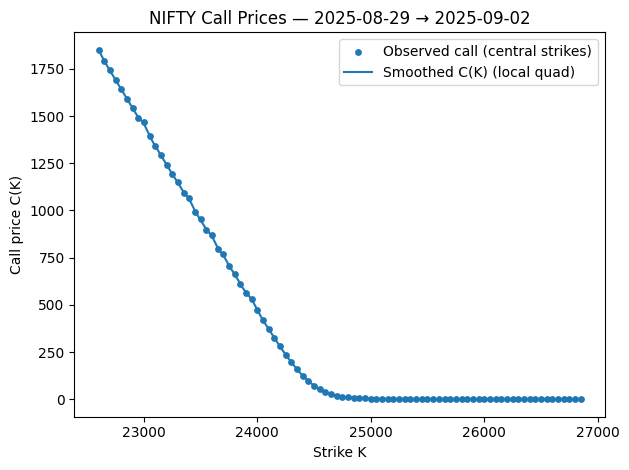

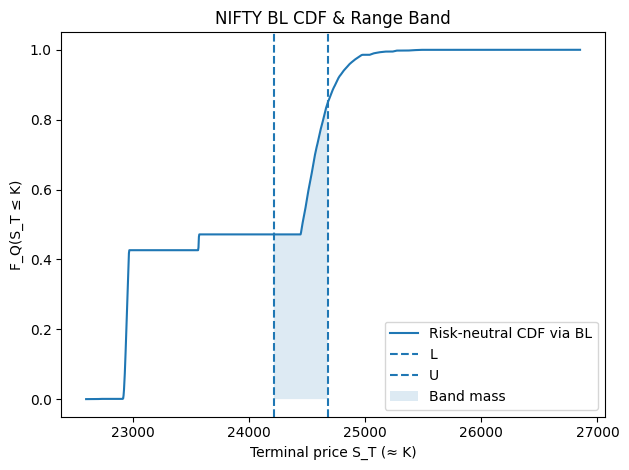

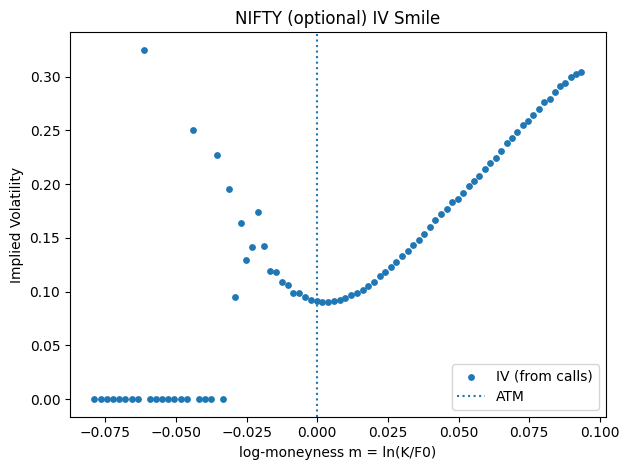

In [9]:
# BL Range/Breakout on NSE UDiFF FO data (simple & self-contained)
# ---------------------------------------------------------------
# Steps:
# 1) Fetch UDiFF FO file for DATE (tries .zip then .gz).
# 2) Save RAW CSV.
# 3) Build a minimal CE/PE chain for one expiry.
# 4) Infer forward F0 and discount D via put–call parity.
# 5) Smooth call-price curve with local quadratic fits; compute dC/dK.
# 6) BL CDF: F(K) = 1 + (1/D) * dC/dK; monotone-fix; normalize.
# 7) Define band [L, U] (method = "atm_iv" or "straddle"), compute probabilities, print prediction.
# 8) Plots: prices & smooth curve; CDF with band; (optional) IV smile if method uses IV.

import io, zipfile, gzip, requests, math, numpy as np, pandas as pd, datetime as dt
import matplotlib.pyplot as plt
from pathlib import Path

# -----------------------
# Config (edit these)
# -----------------------
DATE = "2025-08-29"          # target trade date (UDiFF file exists for this in your tests)
SYMBOL = None                # None = auto-pick (prefers index symbols); or set "NIFTY" / "BANKNIFTY" / ...
BAND_METHOD = "atm_iv"       # "atm_iv" (uses IV) or "straddle" (no IV)
K_BAND_MULT = 1.0            # band width multiplier k
SAVE_DIR = Path("out_bl_udiff"); SAVE_DIR.mkdir(exist_ok=True)

# -----------------------
# Fetch UDiFF FO
# -----------------------
def fetch_udiff_fo(date_str: str):
    d = dt.datetime.strptime(date_str, "%Y-%m-%d").date()
    ymd = d.strftime("%Y%m%d")
    base = f"https://archives.nseindia.com/content/fo/BhavCopy_NSE_FO_0_0_0_{ymd}_F_0000.csv"
    urls = [base + ".zip", base + ".gz"]

    headers = {
        "User-Agent": "Mozilla/5.0",
        "Accept": "text/html,application/xhtml+xml,application/xml;q=0.9,*/*;q=0.8",
        "Referer": "https://www.nseindia.com/",
        "Connection": "keep-alive",
        "Accept-Encoding": "gzip, deflate, br",
    }
    s = requests.Session()
    try: s.get("https://www.nseindia.com/", headers=headers, timeout=15)
    except: pass

    last_err = None
    for url in urls:
        r = s.get(url, headers=headers, timeout=30)
        if r.status_code == 200 and r.content:
            raw = io.BytesIO(r.content)
            try:
                if url.endswith(".zip"):
                    zf = zipfile.ZipFile(raw)
                    name = [n for n in zf.namelist() if n.lower().endswith(".csv")][0]
                    with zf.open(name) as f: return pd.read_csv(f), url
                else:
                    with gzip.GzipFile(fileobj=raw) as gz: return pd.read_csv(gz), url
            except Exception as e:
                last_err = f"parse error: {e}"
        else:
            last_err = f"http {r.status_code}"
    raise RuntimeError(f"UDiFF fetch failed for {date_str}: {last_err}")

raw_df, src_url = fetch_udiff_fo(DATE)
raw_path = SAVE_DIR / f"fo_{DATE.replace('-','')}.raw.csv"
raw_df.to_csv(raw_path, index=False)
print("RAW saved :", raw_path, "from", src_url)
print("Rows      :", len(raw_df))
print("Cols      :", list(raw_df.columns)[:16], "...")

# ------------------------------------------
# Minimal CE/PE chain (auto-pick symbol)
# ------------------------------------------
def build_min_chain_udiff_basic(
    df: pd.DataFrame,
    trade_date: str,
    symbol: str | None = None,
    prefer_symbols=("NIFTY","BANKNIFTY","FINNIFTY","MIDCPNIFTY","NIFTYIT"),
):
    d = df.copy()
    d.columns = [c.upper() for c in d.columns]

    def pick(*names):
        for n in names:
            if n in d.columns:
                return n
        return None

    col_ticker = pick("TCKRSYMB","SYMBOL","SYMB","TCKRSYMBOL")
    col_opttyp = pick("OPTNTP","OPTION_TYP","OPTIONTYPE","OPT_TYPE")
    col_expiry = pick("XPRYDT","EXPIRY_DT","EXPIRY","EXPDATE")
    col_strike = pick("STRKPRIC","STRIKE_PR","STRIKE","STRIKEPRICE")
    col_price  = pick("STTLMPRIC","CLSPRIC","CLOSE","LASTPRIC","SETTLE_PR","SETLPRC","SETTLEPRICE")

    missing = [name for name,val in {
        "ticker":col_ticker,"opt_type":col_opttyp,"expiry":col_expiry,"strike":col_strike,"price":col_price
    }.items() if val is None]
    if missing:
        raise ValueError(f"Missing required columns: {missing}")

    d = d.dropna(subset=[col_opttyp, col_ticker, col_expiry, col_strike, col_price]).copy()
    d[col_opttyp] = d[col_opttyp].astype(str).str.upper().str.strip()
    d = d[d[col_opttyp].isin(["CE","PE","C","P"])]
    if d.empty:
        raise ValueError("No CE/PE rows found in file.")

    d[col_strike] = pd.to_numeric(d[col_strike], errors="coerce")
    d[col_price]  = pd.to_numeric(d[col_price],  errors="coerce")
    d = d.dropna(subset=[col_strike, col_price])

    # choose symbol
    all_syms = d[col_ticker].astype(str).str.upper().unique().tolist()
    if symbol is not None and symbol.upper() in all_syms:
        chosen_symbol = symbol.upper()
    else:
        chosen_symbol = None
        for s in prefer_symbols:
            if s in all_syms:
                chosen_symbol = s; break
        if chosen_symbol is None:
            counts = (d.groupby(col_ticker)[col_opttyp]
                      .apply(lambda x: (x.isin(["CE","PE","C","P"]).sum()))
                      .sort_values(ascending=False))
            chosen_symbol = str(counts.index[0]).upper()

    ds = d[d[col_ticker].astype(str).str.upper() == chosen_symbol].copy()
    tdate = dt.datetime.strptime(trade_date, "%Y-%m-%d").date()
    ds["__EXP__"] = pd.to_datetime(ds[col_expiry], errors="coerce").dt.date
    exps = sorted([e for e in ds["__EXP__"].dropna().unique() if e >= tdate]) or \
           sorted(ds["__EXP__"].dropna().unique())
    if not exps:
        raise ValueError(f"No valid expiries for {chosen_symbol}.")
    expiry = exps[0]
    de = ds[ds["__EXP__"] == expiry].copy()

    de["__OPT__"] = de[col_opttyp].replace({"C":"CE","P":"PE"})
    pvt = (de.pivot_table(index=col_strike, columns="__OPT__", values=col_price, aggfunc="last")
             .rename(columns={"CE":"call_price","PE":"put_price"})
             .reset_index())
    pvt = pvt.rename(columns={col_strike:"strike"})
    pvt = pvt.dropna(subset=["call_price","put_price"])
    pvt = pvt[(pvt["call_price"]>0) & (pvt["put_price"]>0)].sort_values("strike").reset_index(drop=True)

    if len(pvt) < 6:
        raise ValueError(f"Too few CE/PE pairs for {chosen_symbol} @ {expiry}: {len(pvt)}")

    meta = {"chosen_symbol": chosen_symbol, "trade_date": tdate.isoformat(), "expiry": expiry.isoformat(), "price_col": col_price, "rows": int(len(pvt))}
    chain = pvt[["strike","call_price","put_price"]].copy()
    return chain, meta

chain, meta = build_min_chain_udiff_basic(raw_df, DATE, symbol=SYMBOL)
clean_path = SAVE_DIR / f"{meta['chosen_symbol']}_chain_{meta['trade_date'].replace('-','')}_{meta['expiry'].replace('-','')}.csv"
chain.to_csv(clean_path, index=False)
print(f"Symbol {meta['chosen_symbol']}  Expiry {meta['expiry']}  Pairs {meta['rows']}")
print("CLEAN saved:", clean_path)
display(chain.head(10))

# ------------------------------------------
# Parity → F0, D  (regress C-P = D(F0 - K))
# ------------------------------------------
def infer_forward_discount(chain: pd.DataFrame):
    y = chain["call_price"].values - chain["put_price"].values
    X = chain["strike"].values
    A = np.vstack([np.ones_like(X), X]).T
    a, b = np.linalg.lstsq(A, y, rcond=None)[0]
    D = -b
    if not (0 < D < 2):
        # fallback: assume 7% annual when regression unstable
        T_fallback = 1/365
        D = math.exp(-0.07 * T_fallback)
        F0 = np.mean(X + y / D)
        return float(F0), float(D)
    F0 = a / D
    return float(F0), float(D)

F0, D = infer_forward_discount(chain)
S0_est = F0 * D
print(f"F0 ≈ {F0:.2f}   D ≈ {D:.6f}   S0_est ≈ {S0_est:.2f}")

# ------------------------------------------
# Smooth C(K) and derivative via local quad
# ------------------------------------------
def local_quad_smoother(K: np.ndarray, C: np.ndarray, window: int = 7, ridge: float = 1e-8):
    """
    For each K_i, fit C ~ a + b*K + c*K^2 on a local window and return
    smoothed C_i and derivative dC/dK at K_i.
    """
    n = len(K)
    C_s = np.empty(n); dC = np.empty(n)
    for i in range(n):
        lo = max(0, i - window); hi = min(n, i + window + 1)
        Ki = K[lo:hi]; Ci = C[lo:hi]
        # Design matrix [1, K, K^2]
        X = np.vstack([np.ones_like(Ki), Ki, Ki**2]).T
        # ridge regularized least squares
        XtX = X.T @ X + ridge * np.eye(3)
        beta = np.linalg.solve(XtX, X.T @ Ci)
        a, b, c = beta
        K0 = K[i]
        C_s[i] = a + b*K0 + c*K0*K0
        dC[i]  = b + 2*c*K0
    return C_s, dC

# Build call price vector, restrict to central strikes (to reduce wing noise)
# Central window ~ +/- 15% around S0_est (fallback full)
mask_central = (chain["strike"] >= 0.85*S0_est) & (chain["strike"] <= 1.15*S0_est)
chain_c = chain[mask_central].copy()
if len(chain_c) < 10:
    chain_c = chain.copy()

K_obs = chain_c["strike"].values
C_obs = chain_c["call_price"].values
order = np.argsort(K_obs); K_obs = K_obs[order]; C_obs = C_obs[order]

# Smooth on a dense grid within observed bounds
K_grid = np.linspace(K_obs.min(), K_obs.max(), 1201)
# First, interpolate C to grid (piecewise linear), then locally smooth + derivative
C_interp = np.interp(K_grid, K_obs, C_obs)
C_smooth, dC_dK = local_quad_smoother(K_grid, C_interp, window=9, ridge=1e-6)

# ------------------------------------------
# BL CDF from dC/dK
# F(K) = 1 + (1/D) * dC/dK
# ------------------------------------------
F_raw = 1.0 + (1.0 / D) * dC_dK
F_clip = np.clip(F_raw, 0.0, 1.0)
F_mon = np.maximum.accumulate(F_clip)
if F_mon[-1] > 0:
    F_mon = F_mon / F_mon[-1]   # ensure F → 1 at far right

# ------------------------------------------
# Optional: minimal IV & ATM vol for band
# (BSM used ONLY here if BAND_METHOD == "atm_iv")
# ------------------------------------------
def _norm_cdf(x): return 0.5*(1+math.erf(x/math.sqrt(2)))
def bs_call_from_forward(F, K, T, sigma, D):
    if sigma <= 1e-8 or T <= 0: return max(D*(F-K), 0.0)
    vs = sigma*math.sqrt(T)
    d1 = (math.log(F/K)/vs) + 0.5*vs
    d2 = d1 - vs
    return D*(F*_norm_cdf(d1) - K*_norm_cdf(d2))

def implied_vol_from_call(F, K, T, D, C_obs, tol=1e-6, it=100):
    lo, hi = 1e-6, 5.0
    for _ in range(it):
        mid = 0.5*(lo+hi)
        C_mid = bs_call_from_forward(F,K,T,mid,D)
        if abs(C_mid - C_obs) < tol: return mid
        if C_mid > C_obs: hi = mid
        else: lo = mid
    return 0.5*(lo+hi)

# Time to expiry (years) from meta
T_days = max((dt.date.fromisoformat(meta["expiry"]) - dt.date.fromisoformat(meta["trade_date"])).days, 1)
T_years = T_days / 365.0

def choose_band_bounds(F0, D, method="atm_iv", k=1.0):
    S0 = F0*D
    if method == "atm_iv":
        # use nearest strike to spot to estimate ATM IV
        idx = np.argmin(np.abs(chain["strike"].values - S0))
        K_star = float(chain["strike"].values[idx])
        C_star = float(chain["call_price"].values[idx])
        sigma_atm = implied_vol_from_call(F0, K_star, T_years, D, C_star)
        b = k * sigma_atm * math.sqrt(T_years)
        L = S0*(1.0 - b); U = S0*(1.0 + b)
        return S0, L, U, sigma_atm
    else:
        # "straddle" method: band from ATM straddle price (no BS)
        idx = np.argmin(np.abs(chain["strike"].values - S0))
        K_star = float(chain["strike"].values[idx])
        C_star = float(chain["call_price"].values[idx])
        P_star = float(chain["put_price"].values[idx])
        rel_move = (C_star + P_star) / max(S0, 1e-9)   # rough implied move proxy
        b = k * rel_move
        L = S0*(1.0 - b); U = S0*(1.0 + b)
        return S0, L, U, None

S0_est, L, U, sigma_atm = choose_band_bounds(F0, D, method=BAND_METHOD, k=K_BAND_MULT)

# ------------------------------------------
# Probabilities & simple prediction
# ------------------------------------------
def interp_cdf(x): return float(np.interp(x, K_grid, F_mon))
F_L = interp_cdf(L); F_U = interp_cdf(U)
p_range = max(0.0, F_U - F_L)
p_down  = max(0.0, F_L)
p_up    = max(0.0, 1.0 - F_U)
s = p_range + p_down + p_up
if s > 0: p_range, p_down, p_up = p_range/s, p_down/s, p_up/s

if p_range >= 0.55:
    final_pred = f"Predict: RANGE (≥ band), confidence ~{p_range:.1%}"
elif p_up >= p_down:
    final_pred = f"Predict: UPSIDE BREAKOUT (> U), prob ~{p_up:.1%}"
else:
    final_pred = f"Predict: DOWNSIDE BREAKOUT (< L), prob ~{p_down:.1%}"

print("\n=== Inputs & band ===")
print(f"Symbol {meta['chosen_symbol']}   Trade {meta['trade_date']}   Expiry {meta['expiry']}   T={T_years:.5f}y")
print(f"S0_est {S0_est:.2f}   F0 {F0:.2f}   D {D:.6f}")
if BAND_METHOD == "atm_iv":
    print(f"ATM IV ≈ {sigma_atm:.2%}")
print(f"L {L:.2f}   U {U:.2f}")

print("\n=== Probabilities (risk-neutral) ===")
print(f"P_range (L≤S_T≤U): {p_range:.2%}")
print(f"P_up    (S_T>U)  : {p_up:.2%}")
print(f"P_down  (S_T<L)  : {p_down:.2%}")

print("\n=== Final model output ===")
print(final_pred)

# -----------------------
# Visuals
# -----------------------
# 1) Prices & smooth call curve
plt.figure()
plt.scatter(K_obs, C_obs, label="Observed call (central strikes)", s=15)
plt.plot(K_grid, C_smooth, label="Smoothed C(K) (local quad)")
plt.xlabel("Strike K")
plt.ylabel("Call price C(K)")
plt.title(f"{meta['chosen_symbol']} Call Prices — {meta['trade_date']} → {meta['expiry']}")
plt.legend(); plt.tight_layout()
plt.savefig(SAVE_DIR / f"{meta['chosen_symbol']}_callcurve_{meta['trade_date']}_{meta['expiry']}.png", dpi=140)
plt.show()

# 2) BL CDF with band
plt.figure()
plt.plot(K_grid, F_mon, label="Risk-neutral CDF via BL")
plt.axvline(L, linestyle="--", label="L")
plt.axvline(U, linestyle="--", label="U")
plt.fill_between(K_grid, F_mon, where=(K_grid>=L) & (K_grid<=U), alpha=0.15, label="Band mass")
plt.xlabel("Terminal price S_T (≈ K)")
plt.ylabel("F_Q(S_T ≤ K)")
plt.title(f"{meta['chosen_symbol']} BL CDF & Range Band")
plt.legend(); plt.tight_layout()
plt.savefig(SAVE_DIR / f"{meta['chosen_symbol']}_cdf_{meta['trade_date']}_{meta['expiry']}.png", dpi=140)
plt.show()

# 3) Optional: IV smile (only if we used atm_iv; otherwise skip)
if BAND_METHOD == "atm_iv":
    iv_list = []
    for k_i, c_i in zip(chain_c["strike"].values, chain_c["call_price"].values):
        try:
            iv_list.append(implied_vol_from_call(F0, float(k_i), T_years, D, float(c_i)))
        except Exception:
            iv_list.append(np.nan)
    iv_arr = np.array(iv_list, dtype=float)
    m_arr = np.log(chain_c["strike"].values / F0)
    plt.figure()
    plt.scatter(m_arr[np.isfinite(iv_arr)], iv_arr[np.isfinite(iv_arr)], s=15, label="IV (from calls)")
    plt.axvline(0.0, linestyle=":", label="ATM")
    plt.xlabel("log-moneyness m = ln(K/F0)")
    plt.ylabel("Implied Volatility")
    plt.title(f"{meta['chosen_symbol']} (optional) IV Smile")
    plt.legend(); plt.tight_layout()
    plt.savefig(SAVE_DIR / f"{meta['chosen_symbol']}_iv_{meta['trade_date']}_{meta['expiry']}.png", dpi=140)
    plt.show()


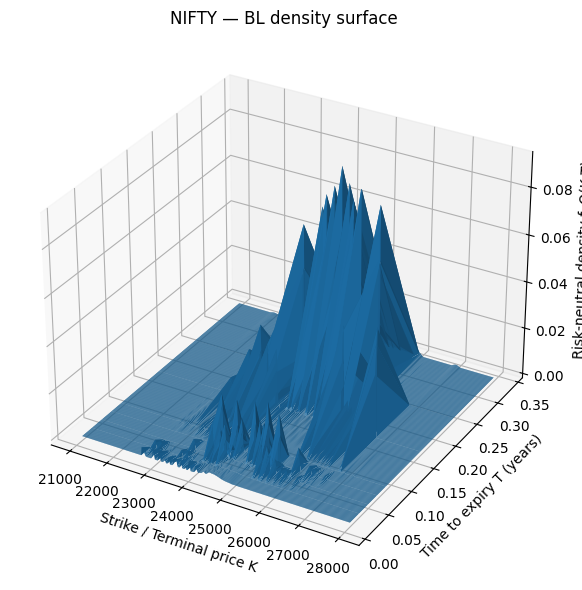

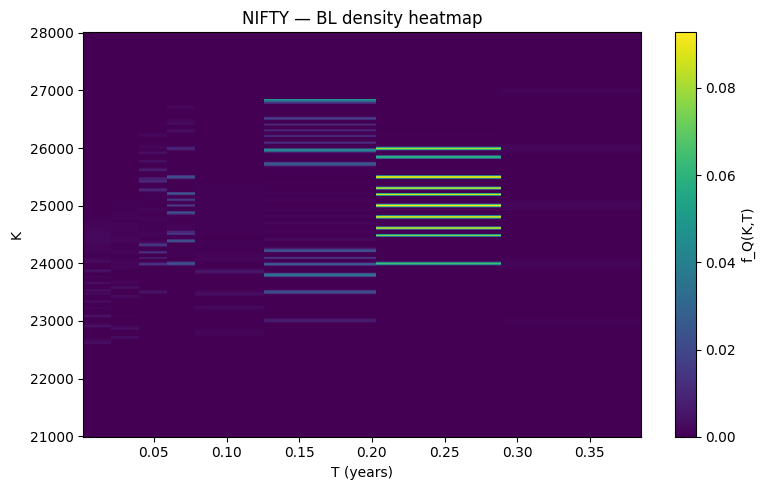

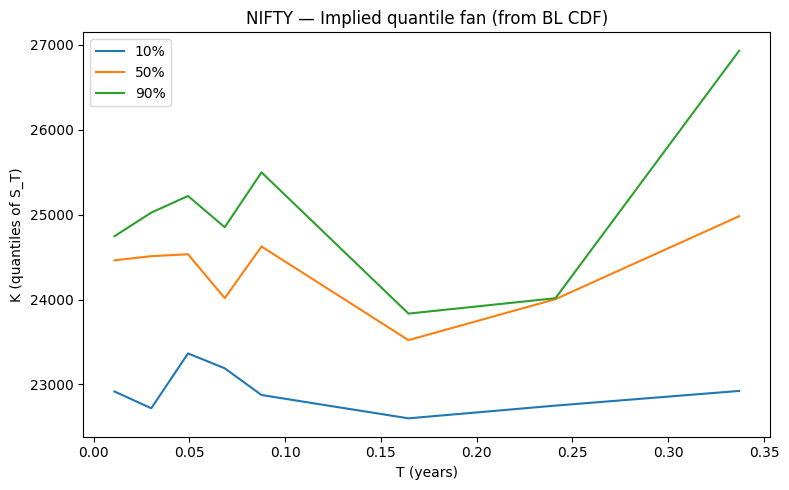

In [10]:
# === BL 3D density surface from UDiFF FO (multi-expiry, one trade date) ===
# Minimal deps: pandas, numpy, matplotlib

import numpy as np, pandas as pd, matplotlib.pyplot as plt, datetime as dt
from pathlib import Path
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 (needed for 3D)

# ----------------------------
# Config
# ----------------------------
RAW_CSV_PATH = "data_nse_udiff/fo_20250829.raw.csv"  # <- set if not using raw_df
SYMBOL       = None   # None = auto-pick (prefers index symbols); or "NIFTY", "BANKNIFTY", ...
MIN_PAIRS    = 12     # min CE/PE pairs per expiry to include
CENTRAL_BAND = 0.15   # use strikes in [S0*(1-0.15), S0*(1+0.15)] to smooth
K_GRID_N     = 400    # global strike grid resolution for the surface
MAX_EXPS     = 8      # cap the number of expiries plotted for readability

# ----------------------------
# 0) Load RAW (if not in memory)
# ----------------------------
try:
    raw_df
except NameError:
    raw_df = pd.read_csv(RAW_CSV_PATH)

# ----------------------------
# 1) Minimal CE/PE chain builder by expiry
# ----------------------------
def build_symbol_chains_udiff(df: pd.DataFrame, symbol: str | None = None,
                              prefer=("NIFTY","BANKNIFTY","FINNIFTY","MIDCPNIFTY","NIFTYIT")):
    d = df.copy()
    d.columns = [c.upper() for c in d.columns]

    def pick(*names):
        for n in names:
            if n in d.columns: return n
        return None

    col_ticker = pick("TCKRSYMB","SYMBOL","SYMB")
    col_opttyp = pick("OPTNTP","OPTION_TYP","OPTIONTYPE","OPT_TYPE")
    col_expiry = pick("XPRYDT","EXPIRY_DT","EXPIRY","EXPDATE")
    col_strike = pick("STRKPRIC","STRIKE_PR","STRIKE","STRIKEPRICE")
    col_price  = pick("STTLMPRIC","CLSPRIC","CLOSE","LASTPRIC","SETTLE_PR","SETLPRC","SETTLEPRICE")
    col_trade  = pick("BIZDT","TRADDT")

    needed = [col_ticker,col_opttyp,col_expiry,col_strike,col_price,col_trade]
    if any(v is None for v in needed):
        raise ValueError(f"Missing required columns (got first 20): {list(d.columns)[:20]}")

    # clean
    d = d.dropna(subset=[col_ticker,col_opttyp,col_expiry,col_strike,col_price,col_trade]).copy()
    d[col_opttyp] = d[col_opttyp].astype(str).str.upper().str.strip()
    d = d[d[col_opttyp].isin(["CE","PE","C","P"])]
    d[col_strike] = pd.to_numeric(d[col_strike], errors="coerce")
    d[col_price]  = pd.to_numeric(d[col_price],  errors="coerce")
    d = d.dropna(subset=[col_strike,col_price])

    # choose symbol
    all_syms = d[col_ticker].astype(str).str.upper().unique().tolist()
    if symbol and symbol.upper() in all_syms:
        chosen = symbol.upper()
    else:
        chosen = None
        for s in prefer:
            if s in all_syms: chosen = s; break
        if chosen is None:
            counts = (d.groupby(col_ticker)[col_opttyp]
                        .apply(lambda x: (x.isin(["CE","PE","C","P"]).sum()))
                        .sort_values(ascending=False))
            chosen = str(counts.index[0]).upper()

    ds = d[d[col_ticker].astype(str).str.upper() == chosen].copy()
    trade_date = pd.to_datetime(ds[col_trade].iloc[0], errors="coerce").date()

    # parse expiry buckets
    ds["__EXP__"] = pd.to_datetime(ds[col_expiry], errors="coerce").dt.date
    exps = sorted(ds["__EXP__"].dropna().unique().tolist())

    chains = []
    for expiry in exps:
        de = ds[ds["__EXP__"] == expiry].copy()
        de["__OPT__"] = de[col_opttyp].replace({"C":"CE","P":"PE"})
        pvt = (de.pivot_table(index=col_strike, columns="__OPT__", values=col_price, aggfunc="last")
                 .rename(columns={"CE":"call_price","PE":"put_price"})
                 .reset_index()).rename(columns={col_strike:"strike"})
        pvt = pvt.dropna(subset=["call_price","put_price"])
        pvt = pvt[(pvt["call_price"]>0) & (pvt["put_price"]>0)].sort_values("strike").reset_index(drop=True)
        if len(pvt) >= MIN_PAIRS:
            chains.append({"expiry": expiry, "trade": trade_date, "df": pvt})

    return chosen, chains

symbol, chains = build_symbol_chains_udiff(raw_df, SYMBOL)
if not chains:
    raise ValueError("No expiries with enough CE/PE pairs after cleaning.")
# Limit number of expiries for clarity (nearest first)
chains = chains[:MAX_EXPS]

# ----------------------------
# 2) Parity → F0, D; pick central strikes
# ----------------------------
def infer_forward_discount(chain_df: pd.DataFrame):
    y = chain_df["call_price"].values - chain_df["put_price"].values
    X = chain_df["strike"].values
    A = np.vstack([np.ones_like(X), X]).T
    a, b = np.linalg.lstsq(A, y, rcond=None)[0]
    D = -b
    if not (0 < D < 2):
        # fallback: tiny T guess just to make a D; F0 by mean parity
        D = np.exp(-0.07 * (1/365))
        F0 = np.mean(X + y / D)
        return float(F0), float(D)
    F0 = a / D
    return float(F0), float(D)

# ----------------------------
# 3) Local quadratic smoother → C, dC/dK, d2C/dK2
# ----------------------------
def local_quad_derivs(K_grid: np.ndarray, C_grid: np.ndarray, window: int = 9, ridge: float = 1e-8):
    """
    For each grid point K0, fit C ~ a + b*(K-K0) + c*(K-K0)^2 on a local window.
    Return arrays: C_smooth (at K0), dC/dK|K0, d2C/dK2|K0.
    """
    n = len(K_grid)
    C_s = np.empty(n); dC = np.empty(n); d2C = np.empty(n)
    for i in range(n):
        K0 = K_grid[i]
        lo = max(0, i - window); hi = min(n, i + window + 1)
        Kloc = K_grid[lo:hi] - K0
        Cloc = C_grid[lo:hi]
        X = np.vstack([np.ones_like(Kloc), Kloc, Kloc**2]).T
        XtX = X.T @ X + ridge * np.eye(3)
        beta = np.linalg.solve(XtX, X.T @ Cloc)
        a, b, c = beta
        C_s[i]  = a
        dC[i]   = b
        d2C[i]  = 2*c
    return C_s, dC, d2C

# ----------------------------
# 4) Build per-expiry pdf via BL and collect on a global K-grid
# ----------------------------
all_S0, all_Kmin, all_Kmax = [], [], []
per_exp = []  # list of dicts with T, Klocal, pdf, cdf, bounds, etc.

for bucket in chains:
    df_e   = bucket["df"]
    expiry = bucket["expiry"]
    tdate  = bucket["trade"]
    T_years = max((expiry - tdate).days, 1) / 365.0

    F0, D = infer_forward_discount(df_e)
    S0 = F0 * D

    # central strikes
    central = df_e[(df_e["strike"] >= (1-CENTRAL_BAND)*S0) &
                   (df_e["strike"] <= (1+CENTRAL_BAND)*S0)].copy()
    if len(central) < MIN_PAIRS//2:
        central = df_e.copy()

    K_obs = central["strike"].values
    C_obs = central["call_price"].values
    order = np.argsort(K_obs); K_obs = K_obs[order]; C_obs = C_obs[order]

    # dense grid in observed range
    K_loc = np.linspace(K_obs.min(), K_obs.max(), 600)
    C_lin = np.interp(K_loc, K_obs, C_obs)
    C_s, dC, d2C = local_quad_derivs(K_loc, C_lin, window=11, ridge=1e-6)

    # BL: CDF and PDF
    F_raw = 1.0 + (1.0 / D) * dC
    F_clip = np.clip(F_raw, 0.0, 1.0)
    F_mon  = np.maximum.accumulate(F_clip)
    if F_mon[-1] > 0:
        F_mon = F_mon / F_mon[-1]

    f_pdf = (1.0 / D) * d2C
    f_pdf = np.clip(f_pdf, 0.0, None)  # avoid small negative noise

    per_exp.append({
        "T": T_years, "K": K_loc, "pdf": f_pdf, "cdf": F_mon,
        "S0": S0, "F0": F0, "D": D, "expiry": expiry.isoformat()
    })

    all_S0.append(S0); all_Kmin.append(K_loc.min()); all_Kmax.append(K_loc.max())

# global K-grid (absolute price axis)
K_min = float(min(all_Kmin)); K_max = float(max(all_Kmax))
K_grid = np.linspace(K_min, K_max, K_GRID_N)

# assemble Z surface: rows = expiries, cols = strikes
T_vals = np.array([row["T"] for row in per_exp])
orderT = np.argsort(T_vals)
T_vals = T_vals[orderT]
per_exp = [per_exp[i] for i in orderT]

Z_pdf = np.zeros((len(per_exp), len(K_grid))) * np.nan
for i, row in enumerate(per_exp):
    Z_pdf[i, :] = np.interp(K_grid, row["K"], row["pdf"], left=np.nan, right=np.nan)

# simple NaN → 0 for plotting (areas with no strike coverage)
Z_plot = np.nan_to_num(Z_pdf, nan=0.0)

# ----------------------------
# 5) Plots
# ----------------------------
# A) 3D surface: f_Q(K,T)
fig = plt.figure(figsize=(9,6))
ax = fig.add_subplot(111, projection='3d')
TT, KK = np.meshgrid(T_vals, K_grid, indexing="ij")
ax.plot_surface(KK, TT, Z_plot, rstride=1, cstride=1, linewidth=0, antialiased=True)
ax.set_xlabel("Strike / Terminal price K")
ax.set_ylabel("Time to expiry T (years)")
ax.set_zlabel("Risk-neutral density f_Q(K,T)")
ax.set_title(f"{symbol} — BL density surface")
plt.tight_layout()
plt.show()

# B) Heatmap (often clearer than 3D)
plt.figure(figsize=(8,5))
plt.pcolormesh(TT, KK, Z_plot, shading="auto")
plt.xlabel("T (years)"); plt.ylabel("K")
plt.title(f"{symbol} — BL density heatmap")
plt.colorbar(label="f_Q(K,T)")
plt.tight_layout()
plt.show()

# C) Quantile fan (10%/50%/90%) over T using the CDF at each expiry
q_levels = [0.1, 0.5, 0.9]
quantiles = {q: [] for q in q_levels}
Ts = []
for row in per_exp:
    # invert CDF: K(q) = F^{-1}(q)
    Kq = [float(np.interp(q, row["cdf"], row["K"])) for q in q_levels]
    for q, kq in zip(q_levels, Kq): quantiles[q].append(kq)
    Ts.append(row["T"])
Ts = np.array(Ts)

plt.figure(figsize=(8,5))
for q in q_levels:
    plt.plot(Ts, quantiles[q], label=f"{int(q*100)}%")
plt.xlabel("T (years)"); plt.ylabel("K (quantiles of S_T)")
plt.title(f"{symbol} — Implied quantile fan (from BL CDF)")
plt.legend(); plt.tight_layout()
plt.show()
